# Credit Card Fraud Detection Based on Anomaly Detection Models
####   The ratio of fraud data in the real life is very small and supervised predictive models are always sensitive to unbalanced data. Hence, I apply some anomaly detection models on this dataset first.

In [42]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import IsolationForest
from matplotlib import gridspec
from scipy.stats import multivariate_normal
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load data and check the information of it
df = pd.read_csv('/Users/qiuyu/Desktop/TCR_Intern/QiuYu/data/creditFraud.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [4]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# check the ratio of normal and abnormal data
print('Normal data:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '%')
print('Abnormal data', round(df['Class'].value_counts()[1]/len(df) * 100,2), '%')

Normal data: 99.83 %
Abnormal data 0.17 %


#### Conclusion of data explore:
  On one hand, I find out that all the data in this dataset is the principle components transfered by PCA except the Time and Amount. This means that I have no ideas the meaning of each feature  in this dataset. On the other hand, the data in this dataset is very unbalanced. 
  
  Fortunately, there is no missing value in this dataset, so I don't need to clean it.

## Gaussian Distribution Method
#### Feature Selection

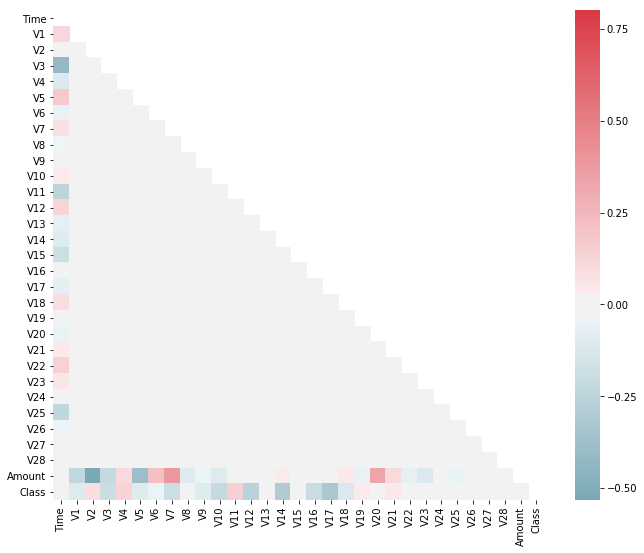

In [6]:
# Check the correlation among these features
corr = df.corr()

# mask the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.8, center=0)

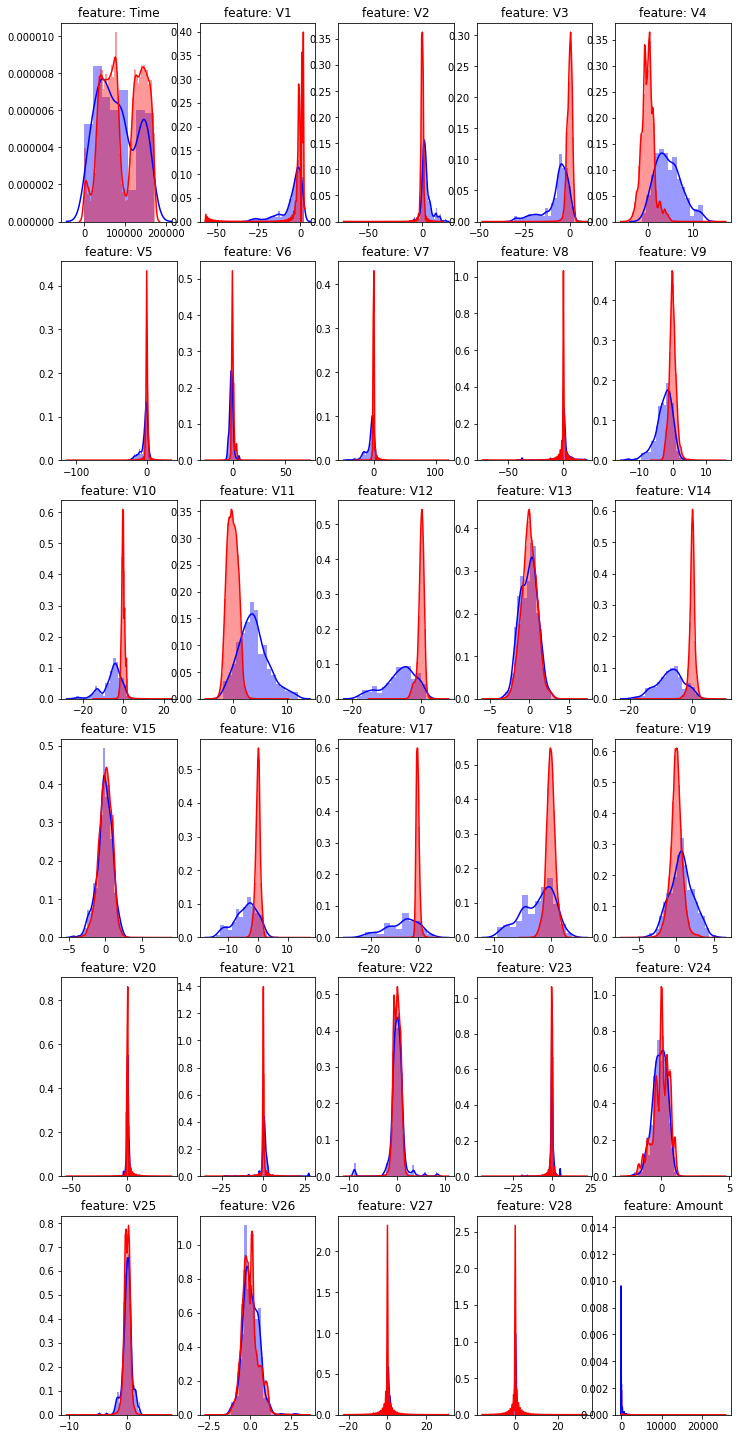

In [7]:
# Check the distribution of each feature according to the class
features = df.iloc[:,0:30].columns
plt.figure(figsize=(12, 6*5))
gs = gridspec.GridSpec(7, 5)
for i, cn in enumerate(df[features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], color = 'blue')
    sns.distplot(df[cn][df.Class == 0], color = 'red')
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.show()

In [8]:
# Select features which are helpful to our model
df_select = df.drop(['Time', 'Amount', 'V1', 'V2', 'V5', 'V6', 'V8', 'V13', 'V15', 'V19', 'V20', 'V21', \
                            'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'], axis = 1, inplace = False)
df_select.head()

,V3,V4,V7,V9,V10,V11,V12,V14,V16,V17,V18,Class
0,2.536347,1.378155,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0
1,0.166480,0.448154,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,0
2,1.773209,0.379780,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0
3,1.792993,-0.863291,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,0
4,1.548718,0.403034,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0


#### From the correlation matrix, we can see that there are no correlation among these feature because they are the pricinple components by PCA. Combined with the result of the distribution plots, I drop all the features which are not correlative to the class.

### Dataset Split

In [9]:
# The training set of this method only contains normal data points
df_normal = df_select[df_select['Class'] == 0]
df_abnormal = df_select[df_select['Class'] == 1]

len_normal = len(df_normal)
len_abnormal = len(df_abnormal)

# The ratio of train, validation and test is 6:2:2
train_size = len_normal * 60 // 100
cv_size = len_normal * 80 // 100
df_train = df_normal[:train_size]
df_cv1 = df_normal[train_size+1:cv_size]
df_test1 = df_normal[cv_size+1:]

# Add the abnormal data into cv and test set
mid = len_abnormal // 2
df_cv2 = df_abnormal[:mid]
df_test2 = df_abnormal[mid+1:]
df_cv = pd.concat([df_cv1, df_cv2], axis=0)
df_test = pd.concat([df_test1, df_test2], axis=0)

# Split the label from dataset
cv_label = df_cv['Class']
test_label = df_test['Class']

df_train.drop(['Class'], axis = 1, inplace = True)
df_cv.drop(['Class'], axis = 1, inplace = True)
df_test.drop(['Class'], axis = 1, inplace = True)

In [10]:
df_train.describe()

,V3,V4,V7,V9,V10,V11,V12,V14,V16,V17,V18
count,170589.000000,170589.000000,170589.000000,170589.000000,170589.000000,170589.000000,170589.000000,170589.000000,170589.000000,170589.000000,170589.000000
mean,0.510488,0.107268,-0.065979,0.024867,-0.015892,0.183943,-0.082422,0.097608,0.002745,0.059241,-0.044863
std,1.277331,1.348868,1.110038,1.138944,1.027284,1.022985,1.072855,0.896470,0.834200,0.762035,0.814111
min,-33.680984,-5.519697,-31.764946,-6.290730,-14.741096,-4.049895,-15.144988,-18.392091,-10.115560,-17.098444,-5.366660
25%,-0.060590,-0.745850,-0.583555,-0.656993,-0.516825,-0.566249,-0.504828,-0.333871,-0.467574,-0.416139,-0.522054
50%,0.625232,0.121144,-0.030588,-0.077471,-0.110223,0.116866,0.112902,0.094386,0.065067,-0.017034,-0.051192
75%,1.298421,0.931744,0.463669,0.643512,0.410577,0.994499,0.618383,0.529025,0.528439,0.435929,0.432942
max,9.382558,16.875344,36.677268,15.594995,23.745136,10.002190,7.848392,10.526766,6.098529,9.253526,5.041069


In [11]:
df_cv.describe()

,V3,V4,V7,V9,V10,V11,V12,V14,V16,V17,V18
count,57108.000000,57108.000000,57108.000000,57108.000000,57108.000000,57108.000000,57108.000000,57108.000000,57108.000000,57108.000000,57108.000000
mean,-0.774732,-0.159412,0.108909,-0.057281,0.060158,-0.256684,0.086922,-0.140714,-0.016905,-0.095603,0.049770
std,1.559719,1.539040,1.401163,1.053360,1.175355,0.964523,0.880174,1.044945,0.970672,0.997743,0.897570
min,-31.103685,-5.683171,-21.922811,-9.283925,-18.271168,-4.797473,-17.769143,-19.214325,-13.563273,-25.162799,-9.498746
25%,-1.617774,-1.022471,-0.506843,-0.675014,-0.541650,-0.990533,-0.349095,-0.577139,-0.504447,-0.569896,-0.488461
50%,-0.752106,-0.325797,0.150603,-0.034654,-0.005476,-0.241459,0.136706,-0.020358,0.045359,-0.154076,0.065863
75%,0.125120,0.468845,0.759267,0.551493,0.631080,0.459988,0.592608,0.450849,0.531509,0.337695,0.604624
max,3.877693,13.129143,36.877368,7.819853,12.114596,12.018913,4.078915,6.894068,8.289890,6.739384,4.029395


In [12]:
df_test.describe()

,V3,V4,V7,V9,V10,V11,V12,V14,V16,V17,V18
count,57107.000000,57107.000000,57107.000000,57107.000000,57107.000000,57107.000000,57107.000000,57107.000000,57107.000000,57107.000000,57107.000000
mean,-0.750080,-0.161027,0.088260,-0.016939,-0.012597,-0.292785,0.159434,-0.150719,0.008796,-0.081145,0.084384
std,1.489203,1.451943,1.398392,1.014671,1.172147,0.941633,0.843865,1.009100,0.898289,0.915816,0.837953
min,-48.325589,-5.266509,-43.557242,-13.434066,-24.588262,-4.010268,-18.683715,-15.623187,-14.129855,-22.667905,-9.264609
25%,-1.592077,-0.931241,-0.487776,-0.558724,-0.610684,-1.007533,-0.254546,-0.620446,-0.428236,-0.577543,-0.424647
50%,-0.724444,-0.338057,0.153331,0.008269,-0.094877,-0.318859,0.209511,-0.027541,0.087491,-0.163563,0.081626
75%,0.113912,0.417580,0.730820,0.552006,0.437837,0.433494,0.641436,0.428515,0.500508,0.357179,0.596367
max,3.937048,15.304184,120.589494,7.871113,12.424602,9.413040,4.293342,6.881310,17.315112,6.498922,4.079390


### Build Model

In [19]:
# Standardize the feature
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

In [14]:
# Find parameter for each col in df for the Gaussian distribution
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    print('The mean of normal data is: ' + '\n' + str(mu))
    print('The sigama of normal data is: ' + '\n' + str(sigma))
    return mu, sigma

In [15]:
# Generate the probability density function/curve/surface for multivariate_normal given mean and cov as p
def multivariateGaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma) # surface hat
    return p.pdf(dataset) # y value on the surface

In [50]:
# Use grid search to find an optimal epsilon
def selectThresholdByCV(probs, label):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    #stepsize = (max(probs) - min(probs)) / 10000000;
    #epsilons = np.arange(min(probs), max(probs), stepsize) #grid search
    #for epsilon in np.nditer(epsilons):
    epsilons = (1.053e-50, 1.053e-51, 1.053e-52, 1.053e-53, 1.053e-54, 1.053e-55, 1.053e-56, 1.053e-57, 1.053e-58, \
               1.053e-59, 1.053e-60)
    for epsilon in epsilons:
        predictions = (probs < epsilon)
        f = f1_score(label, predictions, average = "binary")
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
            recall = recall_score(label, predictions, average = "binary")
            precision = precision_score(label, predictions, average = "binary")
    print('The best threshold is:' + str(best_epsilon))
    print('The F1 score under this epsilon is:' + str(best_f1))
    print('The recall score is: ' + str(recall))
    print('The precision score is:' + str(precision))
    return best_f1, best_epsilon, recall, precision

### Train model

In [60]:
# Step 0: Normalize features
df_train = feature_normalize(df_train)
df_cv = feature_normalize(df_cv)
df_test = feature_normalize(df_test)

# Step 1: training
mu, sigma = estimateGaussian(df_train)

# Apply model on different datasets with same parameter mu & sigma
p_cv = multivariateGaussian(df_cv, mu, sigma)

# Step 2: CV to find optimal threshold epBest
fscore, epBest, recall, precision = selectThresholdByCV(p_cv, cv_label)

The mean of normal data is: 
V3     4.188336e-18
V4    -1.778294e-17
V7     9.426440e-18
V9    -2.928679e-18
V10    3.203974e-18
V11   -1.282794e-17
V12    2.961350e-17
V14    4.483807e-17
V16    1.558187e-17
V17   -1.696941e-17
V18    2.017534e-18
dtype: float64
The sigama of normal data is: 
[[ 1.00000586  0.0172367   0.01489944 -0.02662414 -0.04816496 -0.0025569
   0.00766271 -0.12177593 -0.13507256 -0.11045479 -0.08851017]
 [ 0.0172367   1.00000586  0.02865102  0.02714027  0.00318716 -0.0355545
   0.05536094  0.06343829 -0.00937761  0.11129322  0.00942683]
 [ 0.01489944  0.02865102  1.00000586 -0.003654   -0.04664325  0.05735601
  -0.0720333  -0.08514247 -0.0490046  -0.15922111 -0.03262318]
 [-0.02662414  0.02714027 -0.003654    1.00000586 -0.05974242  0.03478971
  -0.17662135  0.04898726 -0.0867342   0.00955158 -0.01215696]
 [-0.04816496  0.00318716 -0.04664325 -0.05974242  1.00000586  0.06478842
  -0.06122106 -0.1780945  -0.03971583 -0.09932384 -0.02752551]
 [-0.0025569  -0.03555

### Make prediction on test data

In [18]:
# Step 3: prediction on test data
p_test = multivariateGaussian(df_test,mu,sigma)
predictions = (p_test < epBest)

# Calculate f1 score
f = f1_score(test_label, predictions, average = "binary")
recall = recall_score(test_label, predictions, average = "binary")
precision = precision_score(test_label, predictions, average = "binary")
print('F1 score of the model running on test data set: ' + str(f))
print('Recall score of the model running on test data set: ' + str(recall))
print('Precision score of the model running on test data set: ' + str(precision))

F1 score of the model running on test data set: 0.7926267281105991
Recall score of the model running on test data set: 0.7020408163265306
Precision score of the model running on test data set: 0.91005291005291


### Conclusion of Gaussian Distribution method
#### The final outcome of this method is not bad. The advantage of this model is that it does not need a balanced data and well-labeled training set. However, the best threshold in this method is not easy to find. I find it by  grid search but the runtime is long.